In [7]:
import Pkg
Pkg.activate("..")

using MolecularGraph
using MolecularGraph.Geometry

In [70]:
using MolecularGraph.Graph
using LinearAlgebra

mutable struct ForceConstraints
    mincycle::Dict{Int,Int} # node, minimum cycle size

    function ForceConstraints(cyclesize::Vector{Set{Int}})
        mincyc = Dict(i => maximum(c) for (i, c) in enumerate(cyclesize))
        new(mincyc)
    end
end


mutable struct ForceDirectedState{G<:UDGraph}
    graph::G
    constraints::ForceConstraints

    velo::Matrix{Float64}
    force::Matrix{Float64}
    maxiter::Int
    tick::Float64
    stdlength::Float64
    repulsion::Float64
    spring::Float64
    hinge::Float64
    decay::Float64

    coords::Matrix{Float64}

    function ForceDirectedState{G}(graph, init, constraints) where {G<:UDGraph}
        state = new()
        initmat = rawdata(init)
        state.coords = deepcopy(initmat)
        state.constraints = constraints
        state.velo = zeros(size(initmat))
        state.force = zeros(size(initmat))
        state.maxiter = 50
        state.tick = 0.01
        state.stdlength = 1.0
        state.repulsion = 0.00001
        state.spring = 2.0
        state.hinge = 1.0
        state.decay = 0.9
        return state
    end
end


"""
    forcedirected(graph::UDGraph) -> Cartesian2D

Compute 2D embedding based on the graph distance.
"""
function Geometry.forcedirected(
        graph::G, init::Cartesian2D, constraints::ForceConstraints) where {G<:UDGraph}
    state = ForceDirectedState{G}(graph, init, constraints)
    t = state.tick
    for i in 1:state.maxiter
        # Calculate forces
        f = zeros(size(state.coords))
        for n1 in nodekeys(graph)
            p1 = state.coords[n1, :]
            # Repulsion constraints
            for n2 in nodekeys(graph)
                n2 == n1 && continue
                p2 = state.coords[n2, :]
                factor = min(state.repulsion / norm(p2 - p1) ^ 2, state.repulsion * 100)
                f[n1, :] -= factor * normalize(p2 - p1)
            end
            # Spring constraint
            for nbr in neighborkeys(graph, n1)
                pnbr = state.coords[nbr, :]
                factor = (norm(pnbr - p1) - state.stdlength) * state.spring
                f[n1, :] += factor * normalize(pnbr - p1)
            end
            # Hinge constraint
            if degree(graph, n1) == 2
                (a, b) = neighborkeys(graph, n1)
                p1a = state.coords[a, :] - p1
                p1b = state.coords[b, :] - p1
                minc = state.constraints.mincycle[n1]
                ang = cos(pi - 2pi / minc)
                cross = p1a[1] * p1b[2] - p1b[1] * p1a[2]
                direction = cross >= 0 ? 1 : -1
                factor = (dot(p1a, p1b) / (norm(p1a) * norm(p1b)) - ang) * state.hinge
                rotation = r -> [cos(r) -sin(r); sin(r) cos(r)]
                normveca = rotation(pi / 2 * direction) * normalize(p1a - p1)
                f[a, :] += factor * normveca
                normvecb = rotation(pi / 2 * direction) * normalize(p1b - p1)
                f[b, :] += factor * normvecb
            end
        end
        # Apply forces
        energy = 0.0
        for n1 in nodekeys(graph)
            state.velo[n1, :] += (state.force[n1, :] + f[n1, :]) / 2 * t
            state.force[n1, :] = f[n1, :]
            state.coords[n1, :] += state.velo[n1, :] * t + state.force[n1, :] * (t ^ 2) * 0.5
            energy += norm(state.force[n1, :])
        end
        println(energy)
        energy < 0.001 && break
    end
    return Cartesian2D(state.coords)
end

MolecularGraph.Geometry.forcedirected

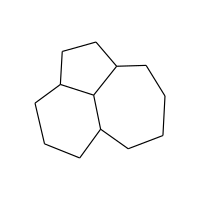

9.131439002980619
9.129853166420096
9.126681692558481
9.12192498685669
9.115583674928978
9.107658623640768
9.098150969556904
9.087062155014124
9.074393972161731
9.060148615385668
9.044328742603923
9.026937545995247
9.007978832799235
8.98745711690309
8.965377722009528
8.941746897260108
8.916571946268347
8.889861370595582
8.861625028777464
8.831874312076389
8.80062233819085
8.767884164188295
8.733677019935362
8.698020563263903
8.660937158016925
8.62245217594231
8.582594323117041
8.541395991155776
8.498893632845915
8.455128161012105
8.410145368302114
8.36399636416479
8.316738023540841
8.268433439728614
8.219152371611024
8.168971673140184
8.117975691049104
8.066256615812415
8.013914771843513
7.9610588371040025
7.907805991413456
7.854282008799155
7.800621334324168
7.746967221766467
7.693472056150961
7.6402980436289765
7.587618517175777
7.535620173025635
7.484506606904589
7.434503536661699


In [71]:
mol = smilestomol("C1CCC2CCC3CCCCC1C23")
coords = graphdistembedding(mol)
constraint = ForceConstraints(mol[:RingSize])
opt =  forcedirected(mol, coords, constraint)
mol.coords[:Cartesian2D] = opt
mol_svg = drawsvg!(mol, 200, 200)
display("image/svg+xml",  mol_svg)